<a href="https://colab.research.google.com/github/sljm12/machine_learning_notebooks/blob/master/Newsheadlines_Simple_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sample code for using Simple Transformers to train a News Headlines classifier.

The dataset is from https://www.kaggle.com/rmisra/news-category-dataset

Check GPU specs

In [1]:
!nvidia-smi

Sat Oct  3 00:01:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip -q install simpletransformers

     |████████████████████████████████| 215kB 4.5MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 317kB 14.7MB/s 
     |████████████████████████████████| 3.0MB 20.8MB/s 
     |████████████████████████████████| 7.2MB 14.8MB/s 
     |████████████████████████████████| 1.1MB 51.9MB/s 
     |████████████████████████████████| 1.7MB 43.8MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 6.7MB 49.2MB/s 
     |████████████████████████████████| 112kB 56.2MB/s 
     |████████████████████████████████| 4.4MB 47.7MB/s 
     |████████████████████████████████| 890kB 50.7MB/s 
     |████████████████████████████████| 1.1MB 46.1MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 163kB 53.7MB/s 
     |████████████████████████████████| 122kB 59.5MB/s 
     |████████████████████████████████| 71kB 9.1MB/

In [3]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import numpy as np
import tensorflow as tf
import seaborn
import matplotlib.pyplot as plt
% matplotlib inline
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)



wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


#Training

In [4]:
!wget -qq https://www.dropbox.com/s/duoi46s4db28xac/news-category-dataset.zip
!unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [5]:
import json
from sklearn.utils import shuffle
data=[]
with open("/content/News_Category_Dataset_v2.json") as f:
  lines = f.readlines()
  for l in lines:
    j=json.loads(l)
    data.append(j)
data_size=len(data)
print("Data Size",data_size)
data=shuffle(data) #Shuffling of the data is impt without it the scores are very bad.

Data Size 200853


In [6]:
train_num = int(data_size*0.6)
val_num = int(data_size * 0.2)
test_num = int(data_size * 0.2)

In [7]:
df=pd.DataFrame(data=data)
num_categories=len(df.groupby("category").count())
print("Number of categories", num_categories)

Number of categories 41


In [8]:
df.head()

,category,headline,authors,link,short_description,date
0,IMPACT,"The Best New Ideas in Washington, From an Unex...","Darius Graham, Contributor\nDirector, DC Socia...",https://www.huffingtonpost.com/entry/best-new-...,"What often goes unrealized is that Washington,...",2013-10-06
1,COMEDY,"PSA: When You Talk S**t About Your Friends, Yo...",Andy McDonald,https://www.huffingtonpost.com/entry/honest-mo...,"""I'll have what they're having.""",2015-08-25
2,POLITICS,"On Veterans Day, We Honor All Who Serve. Trump...","Stephen Peters, ContributorSpokesperson for th...",https://www.huffingtonpost.com/entry/on-vetera...,"As Americans, we take pride in honoring our na...",2017-11-09
3,HOME & LIVING,Country Living Appraises A Late-1800s Dictiona...,,https://www.huffingtonpost.com/entry/country-l...,What It's Worth: $350 Designed by Iowan invent...,2012-09-03
4,ENTERTAINMENT,Don’t Let Blockbusters Keep You From Seeing In...,Matthew Jacobs,https://www.huffingtonpost.com/entry/3-movies-...,It's a quiet place at the box office until the...,2018-04-11


In [9]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df["cat_codes"]=le.fit_transform(df["category"])

In [10]:
df.head()

,category,headline,authors,link,short_description,date,cat_codes
0,IMPACT,"The Best New Ideas in Washington, From an Unex...","Darius Graham, Contributor\nDirector, DC Socia...",https://www.huffingtonpost.com/entry/best-new-...,"What often goes unrealized is that Washington,...",2013-10-06,18
1,COMEDY,"PSA: When You Talk S**t About Your Friends, Yo...",Andy McDonald,https://www.huffingtonpost.com/entry/honest-mo...,"""I'll have what they're having.""",2015-08-25,5
2,POLITICS,"On Veterans Day, We Honor All Who Serve. Trump...","Stephen Peters, ContributorSpokesperson for th...",https://www.huffingtonpost.com/entry/on-vetera...,"As Americans, we take pride in honoring our na...",2017-11-09,24
3,HOME & LIVING,Country Living Appraises A Late-1800s Dictiona...,,https://www.huffingtonpost.com/entry/country-l...,What It's Worth: $350 Designed by Iowan invent...,2012-09-03,17
4,ENTERTAINMENT,Don’t Let Blockbusters Keep You From Seeing In...,Matthew Jacobs,https://www.huffingtonpost.com/entry/3-movies-...,It's a quiet place at the box office until the...,2018-04-11,10


In [11]:
cat_data=df.groupby(["category"]).count()
labels = cat_data.index
labels 
# The LabelEncoder is following the order in labels

Index(['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE',
       'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION',
       'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS',
       'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES',
       'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES',
       'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE',
       'TECH', 'THE WORLDPOST', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS',
       'WOMEN', 'WORLD NEWS', 'WORLDPOST'],
      dtype='object', name='category')

In [12]:
#One hot encoding
encodes=tf.one_hot(df["cat_codes"],num_categories)

In [13]:
#Sanity check on the labels and the one hot encoding
arg_max_label ={}
for l in labels:
  a= df[df["category"] == l]
  row = a.index[0]
  arg_max= np.argmax(encodes[row])
  arg_max_label[arg_max]=l
  print(l,arg_max)

ARTS 0
ARTS & CULTURE 1
BLACK VOICES 2
BUSINESS 3
COLLEGE 4
COMEDY 5
CRIME 6
CULTURE & ARTS 7
DIVORCE 8
EDUCATION 9
ENTERTAINMENT 10
ENVIRONMENT 11
FIFTY 12
FOOD & DRINK 13
GOOD NEWS 14
GREEN 15
HEALTHY LIVING 16
HOME & LIVING 17
IMPACT 18
LATINO VOICES 19
MEDIA 20
MONEY 21
PARENTING 22
PARENTS 23
POLITICS 24
QUEER VOICES 25
RELIGION 26
SCIENCE 27
SPORTS 28
STYLE 29
STYLE & BEAUTY 30
TASTE 31
TECH 32
THE WORLDPOST 33
TRAVEL 34
WEDDINGS 35
WEIRD NEWS 36
WELLNESS 37
WOMEN 38
WORLD NEWS 39
WORLDPOST 40


In [14]:
train_df = df[:train_num]
val_df = df[train_num:train_num+val_num]
test_df = df[train_num+val_num:]

In [15]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

120511
40170
40172


In [16]:
train = train_df[['headline','cat_codes']]
test = test_df[['headline','cat_codes']]

In [17]:
num_labels = len(train['cat_codes'].unique())

In [ ]:
# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=num_labels, use_cuda=True, 
                            args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'num_train_epochs':10, 'train_batch_size':128})
# You can set class weights by using the optional weight argument

# Train the model
model.train_model(train)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_set)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:810: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': -0.010226134499304049, 'eval_loss': 9.060243756874748}


In [ ]:
result

{'eval_loss': 9.060243756874748, 'mcc': -0.010226134499304049}

In [ ]:
predictions, raw_outputs = model.predict(["Obama is the best in the world."])

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [ ]:
predictions[1]

IndexError: ignored

In [ ]:
!cp /content/outputs/pytorch_model.bin "/content/drive/My Drive/Machine Learning/simpleTransformers-News"

In [ ]:
!cp /content/outputs/*.json "/content/drive/My Drive/Machine Learning/simpleTransformers-News"

In [ ]:
!cp /content/outputs/*.txt "/content/drive/My Drive/Machine Learning/simpleTransformers-News"

In [ ]:
!cp /content/outputs/training_args.bin "/content/drive/My Drive/Machine Learning/simpleTransformers-News"

# Loading and Testing

In [18]:
model = ClassificationModel('bert', "/content/drive/My Drive/Machine Learning/simpleTransformers-News", num_labels=41, use_cuda=True, 
                            args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'num_train_epochs':10, 'train_batch_size':128})

In [19]:
predictions, raw_outputs=model.predict(["Singapore’s election: Why aren’t the winners smiling?"])

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [ ]:
predictions

[40]

# Eval

In [20]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:810: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.8336164512816919, 'eval_loss': 0.7642163504487413}


In [21]:
len(wrong_predictions)/len(test)

0.1567011849049089

In [22]:
wrong_predictions[1].__dict__

{'guid': 31,
 'label': 23,
 'text_a': "When Your Heart Is Hurting On Father's Day",
 'text_b': None}

In [24]:
results = []
c=0
for i in test.itertuples():
  pred = np.argmax(tf.nn.softmax(model_outputs[c]))
  results.append([c,i.cat_codes, pred, i.cat_codes==pred])
  c=c+1

In [ ]:
results[:10]

[[0, 27, 5, False],
 [1, 30, 30, True],
 [2, 36, 36, True],
 [3, 18, 18, True],
 [4, 18, 18, True],
 [5, 16, 16, True],
 [6, 10, 10, True],
 [7, 24, 24, True],
 [8, 29, 30, False],
 [9, 23, 23, True]]

In [25]:
results_df=pd.DataFrame(data=results,columns=["id","actual","pred","match"])

In [27]:
import sklearn
cm = sklearn.metrics.confusion_matrix(results_df["actual"], results_df["pred"], normalize="true")

In [28]:
cm

array([[0.66666667, 0.04040404, 0.01346801, ..., 0.        , 0.        ,
        0.003367  ],
       [0.02580645, 0.70645161, 0.01290323, ..., 0.01935484, 0.        ,
        0.        ],
       [0.00446927, 0.00223464, 0.76871508, ..., 0.00446927, 0.        ,
        0.00223464],
       ...,
       [0.00293686, 0.00293686, 0.00881057, ..., 0.75036711, 0.        ,
        0.00146843],
       [0.        , 0.        , 0.        , ..., 0.00219298, 0.67982456,
        0.02850877],
       [0.00372439, 0.        , 0.00744879, ..., 0.        , 0.03538175,
        0.75046555]])

In [43]:
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

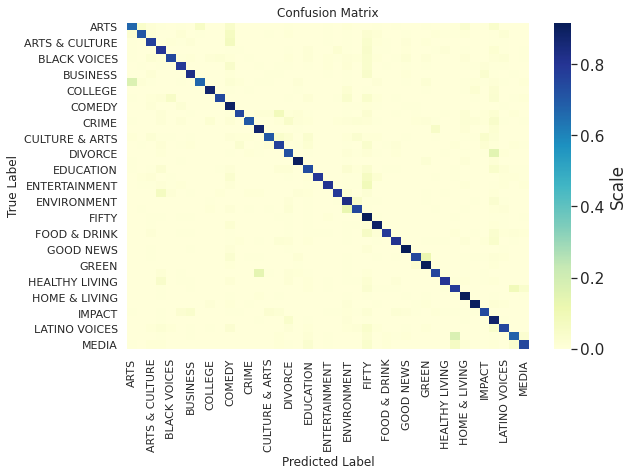

In [44]:
plot_confusion_matrix(cm, labels,"a.png")

In [ ]:
len(model_outputs)

40172

In [ ]:
model_outputs[0]

array([-0.3474 , -3.148  , -0.226  ,  1.206  , -0.5576 , -0.574  ,
       -1.239  ,  0.2053 , -0.9893 , -0.6562 , -0.589  , -0.245  ,
       -0.04276,  0.76   , -0.3748 , -1.203  ,  3.97   ,  0.943  ,
        0.453  , -3.035  , -1.186  ,  0.3564 ,  1.272  , -2.375  ,
       -0.4473 ,  0.1428 ,  1.404  ,  0.8784 , -1.205  , -0.482  ,
        1.1875 , -1.336  , -0.92   , -1.898  ,  0.9985 , -1.301  ,
       -1.801  , 11.734  , -1.133  , -3.047  ,  0.3403 ], dtype=float16)